Question 1

In [10]:
import random
import numpy as np
import pandas as pd

Number_of_Repairmen = 70
avg_nf = []
avg_lsm = []
avg_ltr = []
avg_n = []
avg_percentage = []
avg_ttr = []
avg_q_max = []

whole_nf_list = [[] for x in range(Number_of_Repairmen)]
whole_lsm_list = [[] for x in range(Number_of_Repairmen)]
whole_ltr_list = [[] for x in range(Number_of_Repairmen)]
whole_n_list = [[] for x in range(Number_of_Repairmen)]
whole_percentage_list = [[] for x in range(Number_of_Repairmen)]
whole_ttr_list = [[] for x in range(Number_of_Repairmen)]
whole_q_max_list = [[] for x in range(Number_of_Repairmen)]

for num_of_repairmen in range(1, Number_of_Repairmen+1):
    nf_list = []
    lsm_list = []
    ltr_list = []
    n_list = []
    percentage_list = []
    ttr_list = []
    q_max_list = []


    for iterate in range(10):
        
        class Machine:
            def __init__(self, id):
                self.id = id
                self.life = self.generate_life()

            def generate_life(self):
                return random.randint(100, 200)

        class Repairman:
            def __init__(self, id):
                self.id = id
                self.busy_time = 0
                self.fixed_count = 0
                self.is_idle = True

        class Event:
            BREAKDOWN = 1
            REPAIR_COMPLETE = 2

            def __init__(self, event_type, time, machine_id, repairman_id=None):
                self.event_type = event_type
                self.time = time
                self.machine_id = machine_id
                self.repairman_id = repairman_id

        class MachineRepairSimulation():
            def __init__(self, num_working_machines=63, num_spare_machines=7, num_repairmen=num_of_repairmen, sim_time=40*60):
                self.num_machines = num_working_machines + num_spare_machines
                self.num_working_machines = num_working_machines
                self.num_spare_machines = num_spare_machines
                self.num_repairmen = num_repairmen
                self.sim_time = sim_time
                self.lost_time = 0
                self.repairman_busy_time = []
                self.repairman_fixed_count = []
                self.current_time = 0
                self.breakdown_count = 0
                self.no_spare_count = 0
                self.repaired_machine_count = 0
                self.transport_time_sum = 0
                self.queue_length = 0
                self.max_queue_length = 0
                self.repairmen = [Repairman(i) for i in range(num_repairmen)]
                self.event_list = [Event(Event.BREAKDOWN, 0, i) for i in range(num_working_machines)]

            def generate_repair_time(self):
                return random.randint(30, 60)

            def generate_transport_time(self):
                return random.randint(10, 15)

            def schedule_event(self, event_type, time, machine_id, repairman_id=None):
                event = Event(event_type, time, machine_id, repairman_id)
                self.event_list.append(event)
                self.event_list.sort(key=lambda x: x.time)

            def execute_breakdown_event(self, event):
                self.breakdown_count += 1

                transport_time = self.generate_transport_time()
                self.transport_time_sum += transport_time

                if any(repairman.is_idle for repairman in self.repairmen):
                    repairman = next(repairman for repairman in self.repairmen if repairman.is_idle)
                    repairman.is_idle = False
                    repair_time = self.generate_repair_time()
                    if self.current_time + repair_time < 40*60 :
                        repairman.busy_time += repair_time
                        self.schedule_event(Event.REPAIR_COMPLETE, self.current_time + repair_time, event.machine_id, repairman.id)
                else:
                    self.queue_length += 1 
                    if self.queue_length > self.max_queue_length :
                        self.max_queue_length = self.queue_length

                if self.num_spare_machines > 0:
                    self.num_spare_machines -= 1
                    transport_time = self.generate_transport_time()
                    self.transport_time_sum += transport_time
                    machine = Machine(event.machine_id)
                    self.schedule_event(Event.BREAKDOWN, self.current_time + machine.life, event.machine_id)

                else:
                    self.no_spare_count += 1
                    self.num_working_machines -= 1
                    self.lost_time += (self.event_list[Event == 2].time - self.current_time)*(self.num_machines-self.num_working_machines)

            def execute_repair_complete_event(self, event):
                self.repaired_machine_count += 1

                if self.num_working_machines < self.num_machines - self.num_spare_machines:
                    transport_time = self.generate_transport_time()
                    self.transport_time_sum += transport_time
                    machine = Machine(event.machine_id)
                    self.schedule_event(Event.BREAKDOWN, self.current_time + machine.life, event.machine_id)
                    self.num_working_machines += 1

                else:
                    self.num_spare_machines += 1
                    transport_time = self.generate_transport_time()
                    self.transport_time_sum += transport_time

                repairman = self.repairmen[event.repairman_id]
                repairman.fixed_count += 1

                if self.queue_length > 0:
                    self.queue_length -= 1
                    repair_time = self.generate_repair_time()
                    if self.current_time + repair_time < 40*60:
                        repairman.busy_time += repair_time
                        self.schedule_event(Event.REPAIR_COMPLETE, self.current_time + repair_time, event.machine_id, repairman.id)

                else:
                    repairman.is_idle = True   

            def update_statistics(self):
                self.current_time = self.event_list[0].time

            def controller(self):
                while self.current_time < self.sim_time and self.event_list:
                    event = self.event_list.pop(0)

                    if event.event_type == Event.BREAKDOWN:
                        self.execute_breakdown_event(event)
                    elif event.event_type == Event.REPAIR_COMPLETE:
                        self.execute_repair_complete_event(event)

                    self.update_statistics()

                nf_list.append(self.breakdown_count)
                lsm_list.append(self.no_spare_count)
                ltr_list.append(self.lost_time)
                n_list.append([repairman.fixed_count for repairman in self.repairmen])
                percentage_list.append([repairman.busy_time / (40*60) * 100 for repairman in self.repairmen])
                ttr_list.append(self.transport_time_sum)
                q_max_list.append(self.max_queue_length)

                whole_nf_list[num_of_repairmen-1].append(self.breakdown_count)
                whole_lsm_list[num_of_repairmen-1].append(self.no_spare_count)
                whole_ltr_list[num_of_repairmen-1].append(self.lost_time)
                whole_n_list[num_of_repairmen-1].append(np.mean([repairman.fixed_count for repairman in self.repairmen]))
                whole_percentage_list[num_of_repairmen-1].append(np.mean([repairman.busy_time / (40*60) * 100 for repairman in self.repairmen]))
                whole_ttr_list[num_of_repairmen-1].append(self.transport_time_sum)
                whole_q_max_list[num_of_repairmen-1].append(self.max_queue_length)


        simulation = MachineRepairSimulation()
        simulation.controller()

    avg_nf.append(np.mean(nf_list))
    avg_lsm.append(np.mean(lsm_list))
    avg_ltr.append(np.mean(ltr_list))
    avg_n.append(np.mean(n_list, axis=0))
    avg_percentage.append(np.mean(percentage_list, axis=0))
    avg_ttr.append(np.mean(ttr_list))
    avg_q_max.append(np.mean(q_max_list))

dict_statistics = {'Number of Repairmen':[i+1 for i in range(Number_of_Repairmen)], 'Average Number of Failures':avg_nf,
                   'Average Number of Lost Spare Machines':avg_lsm, 'Average Lost opportunity due to lack of spare car':avg_ltr,
                   'Average Number of Machines Repaired by Each Repairman':[np.mean(state) for state in avg_n], 'Average Employment Percentage of Repairmen':[np.mean(state) for state in avg_percentage],
                   'Average Total Transport Time':avg_ttr, 'Average Maximum Queue Length':avg_q_max}
df_statistics = pd.DataFrame(dict_statistics)
df_statistics.to_excel(r'C:\Users\User\Desktop\Simulation_Analysis_2\Project\Different_Repairmen_Statistics.xlsx')
df_statistics


,Number of Repairmen,Average Number of Failures,Average Number of Lost Spare Machines,Average Lost opportunity due to lack of spare car,Average Number of Machines Repaired by Each Repairman,Average Employment Percentage of Repairmen,Average Total Transport Time,Average Maximum Queue Length
0,1,119.6,112.6,67624.6,53.200000,98.933333,2247.7,67.4
1,2,169.3,162.3,70959.4,52.650000,98.935417,3532.2,64.3
2,3,219.5,212.5,65811.4,53.100000,98.826389,4822.9,60.7
3,4,267.8,260.8,63792.1,52.675000,99.026042,6051.3,59.0
4,5,317.1,310.1,59738.4,52.600000,98.902500,7353.7,58.0
...,...,...,...,...,...,...,...,...
65,66,893.4,886.4,17570.6,13.287879,24.894949,22162.0,0.0
66,67,889.8,882.8,17545.5,13.022388,24.432711,22123.4,0.0
67,68,891.0,884.0,17699.9,12.885294,24.102328,22186.7,0.0
68,69,889.4,882.4,17740.4,12.676812,23.757971,22146.1,0.0


Optimum number of repairmen

In [11]:
Score = []
mean_avg_percentage = [np.mean(state) for state in avg_percentage]
mean_avg_percentage = (mean_avg_percentage - np.mean(mean_avg_percentage)) / np.std(mean_avg_percentage)
avg_ltr = (avg_ltr - np.mean(avg_ltr)) / np.std(avg_ltr)
for i in range(num_of_repairmen):
    Score.append((0.5*mean_avg_percentage[i]) - 0.5*(avg_ltr[i]))
optimal_repairmen_number = list(Score).index(max(list(Score))) + 1
optimal_repairmen_number

16

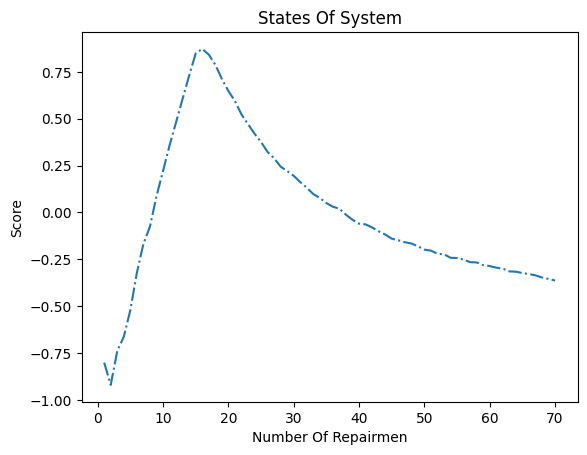

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import io
from PIL import Image
  
plt.plot([i+1 for i in range(Number_of_Repairmen)], Score, '-.')
plt.xlabel("Number Of Repairmen")
plt.ylabel("Score")
plt.title("States Of System")
plt.show()  

Calculation of the relevant statistics of the optimal number of repairmen

In [13]:
import scipy.stats as st
statistics_list = [whole_nf_list,whole_lsm_list,whole_ltr_list,whole_n_list,whole_percentage_list,whole_ttr_list,whole_q_max_list]
statistics_name = ['Number of Failures (NF)','Number of Lost Spare Machines (LSM)','Lost opportunity due to lack of spare car (LTR)','Number of Machines Repaired by Each Repairman (N)','Employment Percentage of Repairmen','Total Transport Time (TTR)','Maximum Queue Length (Q_max)']
point_estimation = []
interval_estimation = []
for statistic in statistics_list:
    point_estimation.append(np.mean(statistic[optimal_repairmen_number-1]))
    interval_estimation.append(st.t.interval(alpha=0.95, df=len(statistic[optimal_repairmen_number-1])-1, loc=np.mean(statistic[optimal_repairmen_number-1]), scale=st.sem(statistic[optimal_repairmen_number-1])))
dict_estimation = {'Statistic' : statistics_name , 'Point Estimation' : point_estimation , 'Interval Estimation' : interval_estimation}
df_estimation = pd.DataFrame(dict_estimation)
df_estimation.to_excel(r'C:\Users\User\Desktop\Simulation_Analysis_2\Project\Optimum_Repairmen_estimation.xlsx')
df_estimation

C:\Users\User\AppData\Local\Temp\ipykernel_14044\4017979051.py:8: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  interval_estimation.append(st.t.interval(alpha=0.95, df=len(statistic[optimal_repairmen_number-1])-1, loc=np.mean(statistic[optimal_repairmen_number-1]), scale=st.sem(statistic[optimal_repairmen_number-1])))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,Statistic,Point Estimation,Interval Estimation
0,Number of Failures (NF),843.500000,"(839.6959570412735, 847.3040429587265)"
1,Number of Lost Spare Machines (LSM),836.500000,"(832.6959570412735, 840.3040429587265)"
2,Lost opportunity due to lack of spare car (LTR),19364.200000,"(18793.469329222327, 19934.930670777674)"
3,Number of Machines Repaired by Each Repairman (N),51.512500,"(51.313889128323545, 51.71111087167646)"
4,Employment Percentage of Repairmen,96.396615,"(96.15021554577811, 96.64301362088855)"
5,Total Transport Time (TTR),20940.200000,"(20852.765812896592, 21027.63418710341)"
6,Maximum Queue Length (Q_max),47.000000,"(nan, nan)"


In [14]:
whole_q_max_list[optimal_repairmen_number-1]

[47, 47, 47, 47, 47, 47, 47, 47, 47, 47]

In [15]:
whole_q_max_list[2]

[61, 61, 60, 61, 60, 61, 61, 61, 60, 61]

Question 2

In [16]:
import random
import numpy as np


Number_of_Repairmen = 30
Number_of_spare_machines = 15
avg_nf = []
avg_lsm = []
avg_ltr = []
avg_n = []
avg_percentage = []
avg_ttr = []
avg_q_max = []
avg_total_hours_worked = []
total_cost = []
Number_of_Repairmen_list = []
Number_of_spare_machines_list = []


for num_of_spare in range(1, Number_of_spare_machines+1):

    for num_of_repairmen in range(1, Number_of_Repairmen+1):

        nf_list = []
        lsm_list = []
        ltr_list = []
        n_list = []
        percentage_list = []
        ttr_list = []
        q_max_list = []
        total_hours_worked_list = []
        
        for iterate in range(10):
            
            class Machine:
                def __init__(self, id):
                    self.id = id
                    self.life = self.generate_life()

                def generate_life(self):
                    return random.randint(100, 200)

            class Repairman:
                def __init__(self, id):
                    self.id = id
                    self.busy_time = 0
                    self.fixed_count = 0
                    self.is_idle = True

            class Event:
                BREAKDOWN = 1
                REPAIR_COMPLETE = 2

                def __init__(self, event_type, time, machine_id, repairman_id=None):
                    self.event_type = event_type
                    self.time = time
                    self.machine_id = machine_id
                    self.repairman_id = repairman_id

            class MachineRepairSimulation():
                def __init__(self, num_working_machines=70-num_of_spare, num_spare_machines=num_of_spare, num_repairmen=num_of_repairmen, sim_time=40*60):
                    self.num_machines = num_working_machines + num_spare_machines
                    self.num_working_machines = num_working_machines
                    self.num_spare_machines = num_spare_machines
                    self.num_repairmen = num_repairmen
                    self.sim_time = sim_time
                    self.lost_time = 0
                    self.repairman_busy_time = []
                    self.repairman_fixed_count = []
                    self.current_time = 0
                    self.breakdown_count = 0
                    self.no_spare_count = 0
                    self.repaired_machine_count = 0
                    self.transport_time_sum = 0
                    self.queue_length = 0
                    self.max_queue_length = 0
                    self.repairmen = [Repairman(i) for i in range(num_repairmen)]
                    self.event_list = [Event(Event.BREAKDOWN, 0, i) for i in range(num_working_machines)]

                def generate_repair_time(self):
                    return random.randint(30, 60)

                def generate_transport_time(self):
                    return random.randint(10, 15)

                def schedule_event(self, event_type, time, machine_id, repairman_id=None):
                    event = Event(event_type, time, machine_id, repairman_id)
                    self.event_list.append(event)
                    self.event_list.sort(key=lambda x: x.time)

                def execute_breakdown_event(self, event):
                    self.breakdown_count += 1

                    transport_time = self.generate_transport_time()
                    self.transport_time_sum += transport_time

                    if any(repairman.is_idle for repairman in self.repairmen):
                        repairman = next(repairman for repairman in self.repairmen if repairman.is_idle)
                        repairman.is_idle = False
                        repair_time = self.generate_repair_time()
                        if self.current_time + repair_time < 40*60 :
                            repairman.busy_time += repair_time
                            self.schedule_event(Event.REPAIR_COMPLETE, self.current_time + repair_time, event.machine_id, repairman.id)
                    else:
                        self.queue_length += 1
                        if self.queue_length > self.max_queue_length :
                            self.max_queue_length = self.queue_length

                    if self.num_spare_machines > 0:
                        self.num_spare_machines -= 1
                        transport_time = self.generate_transport_time()
                        self.transport_time_sum += transport_time
                        machine = Machine(event.machine_id)
                        self.schedule_event(Event.BREAKDOWN, self.current_time + machine.life, event.machine_id)

                    else:
                        self.no_spare_count += 1
                        self.num_working_machines -= 1
                        self.lost_time += (self.event_list[Event == 2].time - self.current_time)*(self.num_machines-self.num_working_machines)

                def execute_repair_complete_event(self, event):
                    self.repaired_machine_count += 1

                    if self.num_working_machines < self.num_machines - self.num_spare_machines:
                        transport_time = self.generate_transport_time()
                        self.transport_time_sum += transport_time
                        machine = Machine(event.machine_id)
                        self.schedule_event(Event.BREAKDOWN, self.current_time + machine.life, event.machine_id)
                        self.num_working_machines += 1

                    else:
                        self.num_spare_machines += 1
                        transport_time = self.generate_transport_time()
                        self.transport_time_sum += transport_time

                    repairman = self.repairmen[event.repairman_id]
                    repairman.fixed_count += 1

                    if self.queue_length > 0:
                        self.queue_length -= 1
                        repair_time = self.generate_repair_time()
                        if self.current_time + repair_time < 40*60 :
                            repairman.busy_time += repair_time
                            self.schedule_event(Event.REPAIR_COMPLETE, self.current_time + repair_time, event.machine_id, repairman.id)

                    else:
                        repairman.is_idle = True   

                def update_statistics(self):
                    self.current_time = self.event_list[0].time

                def controller(self):
                    while self.current_time < self.sim_time and self.event_list:
                        event = self.event_list.pop(0)

                        if event.event_type == Event.BREAKDOWN:
                            self.execute_breakdown_event(event)
                        elif event.event_type == Event.REPAIR_COMPLETE:
                            self.execute_repair_complete_event(event)

                        self.update_statistics()

                    nf_list.append(self.breakdown_count)
                    lsm_list.append(self.no_spare_count)
                    ltr_list.append(self.lost_time)
                    total_hours_worked_list.append(sum([repairman.busy_time for repairman in self.repairmen]))
                    n_list.append([repairman.fixed_count for repairman in self.repairmen])
                    percentage_list.append([repairman.busy_time / (40*60) * 100 for repairman in self.repairmen])
                    ttr_list.append(self.transport_time_sum)
                    q_max_list.append(self.max_queue_length)



            
            simulation = MachineRepairSimulation()
            simulation.controller()

        avg_nf.append(np.mean(nf_list))
        avg_lsm.append(np.mean(lsm_list))
        avg_ltr.append(np.mean(ltr_list))
        avg_n.append(np.mean(n_list, axis=0))
        avg_total_hours_worked.append(np.mean(total_hours_worked_list))
        avg_percentage.append(np.mean(percentage_list, axis=0))
        avg_ttr.append(np.mean(ttr_list))
        avg_q_max.append(np.mean(q_max_list))

        Z = avg_total_hours_worked[-1] + (10 * avg_ltr[-1])
        total_cost.append(Z)
        Number_of_Repairmen_list.append(num_of_repairmen)
        Number_of_spare_machines_list.append(num_of_spare)

dict_result = {'Number of Repairmen':Number_of_Repairmen_list , 'Number of Spare Machines':Number_of_spare_machines_list , 'Total Cost':total_cost}
df_result = pd.DataFrame(dict_result)
df_result.to_excel(r'C:\Users\User\Desktop\Simulation_Analysis_2\Project\Different_Repairmen_and_sparemachines_cost.xlsx')
df_result


,Number of Repairmen,Number of Spare Machines,Total Cost
0,1,1,697272.1
1,2,1,684343.9
2,3,1,665226.2
3,4,1,635473.1
4,5,1,572806.4
...,...,...,...
445,26,15,214984.8
446,27,15,212926.0
447,28,15,212385.9
448,29,15,213212.9


Determining the state with the lowest cost

In [17]:
df_result[df_result['Total Cost'] == min(df_result['Total Cost'])]

,Number of Repairmen,Number of Spare Machines,Total Cost
415,26,14,210045.1


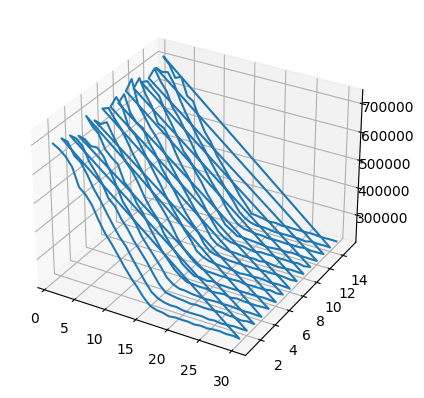

<Figure size 640x480 with 0 Axes>

In [19]:
import numpy as np

x_1 = Number_of_Repairmen_list
x_2 = Number_of_spare_machines_list
z = total_cost
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_1,x_2,z)
plt.show()